In [4]:
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt

Funções

In [5]:
def filter_gaussian(P, Q):
    s1 = P
    s2 = Q

    D = np.zeros([P, Q])  # Compute Distances
    for u in range(P):
        for v in range(Q):
            x = (u-(P/2))**2/(2*s1**2) + (v-(Q/2))**2/(2*s2**2)
            D[u, v] = np.exp(-x)
    return D

In [6]:
#Espectro Visível
heatmap_colors = [
    [1, 0, 1],   # Pink
    [0, 0, 1],   # Blue
    [0, 1, 0],   # Green
    [1, 1, 0],   # Yellow
    [1, 0, 0]    # Red
]

# Function to map values to colors
def map_value_to_color(value, min_val, max_val, colormap):
    # Scale the value to the range [0, len(colormap) - 1]
    scaled_value = (value - min_val) / (max_val - min_val) * (len(colormap) - 1)
    # Determine the two closest colors in the colormap
    idx1 = int(scaled_value)
    idx2 = min(idx1 + 1, len(colormap) - 1)
    # Interpolate between the two colors based on the fractional part
    frac = scaled_value - idx1
    color = [
        (1 - frac) * colormap[idx1][0] + frac * colormap[idx2][0],
        (1 - frac) * colormap[idx1][1] + frac * colormap[idx2][1],
        (1 - frac) * colormap[idx1][2] + frac * colormap[idx2][2]
    ]
    return color

In [7]:
def apply_threshold(img, t):
    img_thresholded = np.ones(img.shape).astype(np.int64)
    img_thresholded[np.where(img < t)] = 0
    return img_thresholded

In [8]:
def convert_RGB_greyscale(img):
    if len(img.shape) > 2:
        img = np.dot(img, [0.2989, 0.5870, 0.1140]).astype(np.int64)
    return img

In [9]:
def otsu(img, len = 256):
    M = np.prod(img.shape)
    vars = []
    hist, _ = np.histogram(img, len, range=(0,len))

    for t in range(0, len):
        img_thresholded = apply_threshold(img, t)
        # classes weights
        class_a = np.sum(hist[:t])/float(M)
        class_b = np.sum(hist[t:])/float(M)

        # classes variances
        if class_a != 0:
            var_a = np.var(img[np.where(img_thresholded == 0)])
        else:
            var_a = 1e9
        if class_b != 0:
            var_b = np.var(img[np.where(img_thresholded == 1)])
        else:
            var_b = 1e9

        
        vars = vars + [class_a*var_a + class_b*var_b]
    
    min_var = np.argmin(vars)
    return apply_threshold(img, min_var), min_var

In [10]:
def erosion(img, footprint = 3): 
    eroded_img = np.zeros(img.shape)

    img_n, img_m = img.shape

    padding_size = int(footprint/2)

    img = np.pad(img, padding_size, constant_values=1)

    for i in range(img_n):
        for j in range(img_m):
            eroded_img[i,j] = np.min(img[i : i + 2*padding_size + 1, j : j + 2*padding_size + 1])

    return eroded_img

In [11]:
def dilation(img, footprint = 3):
    dilated_img = np.zeros(img.shape)

    img_n, img_m = img.shape

    padding_size = int(footprint/2)

    img = np.pad(img, padding_size, constant_values= 0)

    for i in range(img_n):
        for j in range(img_m):
            dilated_img[i,j] = np.max(img[i : i + 2*padding_size + 1, j : j + 2*padding_size + 1])
    
    return dilated_img

In [12]:
def RMSE(H, H_hat):
    return np.sqrt(((H.astype(np.int32) - H_hat.astype(np.int32))**2).mean())

In [13]:
def RMSE_3_channels(H, H_hat):
    error_R = RMSE(H[:,:,0], H_hat[:,:,0])
    error_G = RMSE(H[:,:,1], H_hat[:,:,1])
    error_B = RMSE(H[:,:,2], H_hat[:,:,2])

    return (error_R + error_G + error_B) / 3

In [23]:
input_image = imageio.imread("test_cases_data/skin_lesion_1.jpg")
img = convert_RGB_greyscale(input_image)

In [25]:
otsued_img, _ = otsu(img)

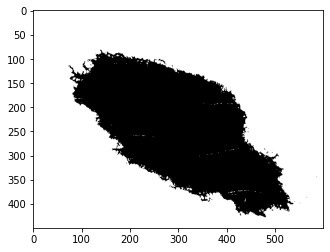

In [27]:
plt.imshow(otsued_img, cmap="gray")

In [30]:
m, n = otsued_img.shape
m

450

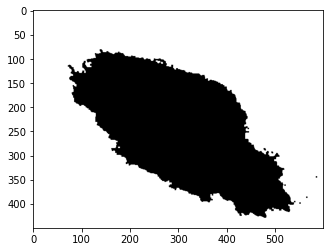

In [31]:
testing_phase = [1,1,2,2,1]

for test in testing_phase:
    if test == 1:
        otsued_img = erosion(otsued_img)
    else:
        otsued_img = dilation(otsued_img)

plt.imshow(otsued_img, cmap="gray")        

finals touches after processing the image

In [59]:
alpha = 0.3

N,M = otsued_img.shape
color_distribuiton = filter_gaussian(M, N)
min_val = np.min(np.array(color_distribuiton))
max_val = np.max(np.array(color_distribuiton))

heatmap_image = np.zeros([M,N,3])
for i in range(M):
    for j in range(N):
        heatmap_image[i,j] = map_value_to_color(color_distribuiton[i,j], min_val, max_val, heatmap_colors)
    
img_color = np.ones([M,N,3])
indexes = np.where(otsued_img == 0)
img_color[indexes] = heatmap_image[indexes]

grey_image = img
grey_image_normalized = grey_image / np.max(grey_image)

grey_image = np.stack([grey_image_normalized, grey_image_normalized, grey_image_normalized],axis=-1)
mixed_image = (1-alpha)* grey_image + alpha*img_color

In [1]:
def generate_color_mapping(otsued_img):
    N,M = otsued_img.shape
    color_distribuiton = filter_gaussian(M, N)
    min_val = np.min(np.array(color_distribuiton))
    max_val = np.max(np.array(color_distribuiton))

    heatmap_image = np.zeros([M,N,3])
    for i in range(M):
        for j in range(N):
            heatmap_image[i,j] = map_value_to_color(color_distribuiton[i,j], min_val, max_val, heatmap_colors)
        
    img_color = np.ones([M,N,3])
    indexes = np.where(otsued_img == 0)
    img_color[indexes] = heatmap_image[indexes]
    return img_color

In [18]:
def normalize_grey_image(img):
    return img/np.max(img)

In [20]:
def alpha_composition(grey_image, img_color, alpha = 0.3):
    aux = np.stack([grey_image,grey_image,grey_image], axis=-1)
    return (1-alpha)*aux + alpha*img_color

In [32]:
img_color = generate_color_mapping(otsued_img)
new_grey_image = normalize_grey_image(img)
h_hat = alpha_composition(new_grey_image, img_color)

IndexError: index 450 is out of bounds for axis 1 with size 450

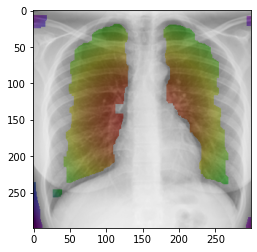

In [22]:
plt.imshow((h_hat*255).astype(np.uint8))